In [3]:
import os
import random
import numpy as np
from pathlib import Path
import pandas as pd
import glob
import re
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
from datetime import datetime

## 본 코드 실행 전 테스트

In [5]:
def get_random_npz_files(base_dir, num_files=4):
    """
    AMASS 폴더에서 랜덤하게 npz 파일들을 선택하여 반환
    
    Args:
        base_dir: AMASS 데이터가 있는 기본 디렉토리
        num_files: 선택할 파일 개수
    
    Returns:
        선택된 파일들의 경로 리스트
    """
    # 모든 npz 파일 찾기
    all_npz_files = []
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.npz'):
                full_path = os.path.join(root, file)
                all_npz_files.append(full_path)
    
    print(f"총 {len(all_npz_files)}개의 npz 파일을 찾았습니다.")
    
    # 랜덤하게 선택
    if len(all_npz_files) < num_files:
        print(f"요청한 파일 개수({num_files})가 전체 파일 개수({len(all_npz_files)})보다 많습니다.")
        selected_files = all_npz_files
    else:
        selected_files = random.sample(all_npz_files, num_files)
    
    return selected_files

def npz_to_dataframe(npz_path):
    """
    NPZ 파일을 DataFrame으로 변환하는 함수
    """
    # 1) NPZ 로드
    data = np.load(npz_path, allow_pickle=True)
    if 'poses' not in data or 'trans' not in data:
        raise KeyError("Input NPZ must contain 'poses' and 'trans' arrays.")
    poses = data['poses']           # (T, N) axis-angle
    trans = data['trans']           # (T, 3) root translation
    T = poses.shape[0]

    # 1.1) 모션 캡처 프레임 속도 로드 (Time 계산용)
    frame_rate = data.get('mocap_frame_rate', None)
    if frame_rate is None:
        frame_rate = data.get('mocap_framerate', None)
    if frame_rate is None:
        raise KeyError("Input NPZ must contain 'mocap_frame_rate' or 'mocap_framerate' array to compute Time column.")

    # 2) 축-각(axis-angle) 재구성: (T, num_joints, 3)
    num_joints = poses.shape[1] // 3
    if poses.shape[1] % 3 != 0:
        raise ValueError(f"Invalid poses shape: {poses.shape}. Second dimension must be divisible by 3.")
    axis_full = poses.reshape(T, num_joints, 3)

    # 3) 포지션 재구성: (T, num_joints, 3)
    pos_full = np.zeros((T, num_joints, 3))
    pos_full[:, 0, :] = trans

    # 4) 원래 22개 joint만 추출
    if num_joints < 22:
        raise ValueError(f"Not enough joints: found {num_joints}, need at least 22.")
    axis22 = axis_full[:, :22, :]  # (T, 22, 3)
    pos22  = pos_full[:, :22, :]

    # 5) angles와 positions 별도 평탄화
    angle_flat = axis22.reshape(T, 22 * 3)
    pos_flat   = pos22.reshape(T, 22 * 3)
    flat = np.hstack([angle_flat, pos_flat])

    # 6) 사용자 지정 관절 순서
    joints_order = [
        'pelvis',
        'left_hip','right_hip',
        'spine1',
        'left_knee','right_knee',
        'spine2',
        'left_ankle','right_ankle',
        'spine3',
        'left_foot','right_foot',
        'neck',
        'left_collar','right_collar',
        'head',
        'left_shoulder','right_shoulder',
        'left_elbow','right_elbow',
        'left_wrist','right_wrist'
    ]

    # 7) 컬럼 이름 생성
    def make_labels(names, suffixes):
        return [f"{name}_{suf}" for name in names for suf in suffixes]
    angle_labels = make_labels(joints_order, ['wx','wy','wz'])
    pos_labels   = make_labels(joints_order, ['px','py','pz'])
    columns = angle_labels + pos_labels

    # 8) DataFrame 생성 (Frame, Time 컬럼 제외)
    df = pd.DataFrame(flat, columns=columns)
    
    return df, frame_rate

def interpolate_transition_with_slerp(df1, df2, transition_frames=10):
    """
    두 DataFrame 사이에 Slerp를 사용한 자연스러운 트랜지션을 생성
    
    Args:
        df1: 첫 번째 DataFrame
        df2: 두 번째 DataFrame  
        transition_frames: 트랜지션에 사용할 프레임 수
    
    Returns:
        트랜지션이 추가된 DataFrame
    """
    # 마지막 프레임과 첫 번째 프레임 추출
    last_frame = df1.iloc[-1].copy()
    first_frame = df2.iloc[0].copy()
    
    # 관절 순서
    joints_order = [
        'pelvis', 'left_hip', 'right_hip', 'spine1', 'left_knee', 'right_knee',
        'spine2', 'left_ankle', 'right_ankle', 'spine3', 'left_foot', 'right_foot',
        'neck', 'left_collar', 'right_collar', 'head', 'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist'
    ]
    
    # 트랜지션 프레임들 생성
    transition_data = []
    
    for i in range(1, transition_frames + 1):
        # 0~1 사이의 interpolation factor
        alpha = i / (transition_frames + 1)
        
        transition_frame = {}
        
        # 각 관절에 대해 처리
        for joint in joints_order:
            # 회전 (wx, wy, wz) - Slerp 사용
            start_rot = np.array([last_frame[f'{joint}_wx'], 
                                last_frame[f'{joint}_wy'], 
                                last_frame[f'{joint}_wz']])
            end_rot = np.array([first_frame[f'{joint}_wx'], 
                                first_frame[f'{joint}_wy'], 
                                first_frame[f'{joint}_wz']])
            
            # axis-angle을 Rotation 객체로 변환
            try:
                # 영벡터인 경우 처리
                if np.allclose(start_rot, 0) and np.allclose(end_rot, 0):
                    # 둘 다 영벡터면 그대로 유지
                    interpolated_rot = np.zeros(3)
                elif np.allclose(start_rot, 0):
                    # 시작이 영벡터면 선형 보간
                    interpolated_rot = end_rot * alpha
                elif np.allclose(end_rot, 0):
                    # 끝이 영벡터면 선형 보간
                    interpolated_rot = start_rot * (1 - alpha)
                else:
                    # 정상적인 경우 Slerp 사용
                    start_rotation = R.from_rotvec(start_rot)
                    end_rotation = R.from_rotvec(end_rot)
                    
                    # Slerp 객체 생성
                    times = np.array([0, 1])
                    rotations = R.concatenate([start_rotation, end_rotation])
                    slerp = Slerp(times, rotations)
                    
                    # 보간된 회전 계산
                    interpolated_rotation = slerp(alpha)
                    interpolated_rot = interpolated_rotation.as_rotvec()
                    
            except Exception as e:
                # Slerp 실패 시 선형 보간으로 대체
                print(f"Slerp failed for {joint}, using linear interpolation: {e}")
                interpolated_rot = start_rot * (1 - alpha) + end_rot * alpha
            
            # 회전 값 저장
            transition_frame[f'{joint}_wx'] = interpolated_rot[0]
            transition_frame[f'{joint}_wy'] = interpolated_rot[1]
            transition_frame[f'{joint}_wz'] = interpolated_rot[2]
            
            # 위치 (px, py, pz) - 선형 보간 사용
            start_pos = np.array([last_frame[f'{joint}_px'], 
                                last_frame[f'{joint}_py'], 
                                last_frame[f'{joint}_pz']])
            end_pos = np.array([first_frame[f'{joint}_px'], 
                                first_frame[f'{joint}_py'], 
                                first_frame[f'{joint}_pz']])
            
            interpolated_pos = start_pos * (1 - alpha) + end_pos * alpha
            
            # 위치 값 저장
            transition_frame[f'{joint}_px'] = interpolated_pos[0]
            transition_frame[f'{joint}_py'] = interpolated_pos[1]
            transition_frame[f'{joint}_pz'] = interpolated_pos[2]
        
        transition_data.append(transition_frame)
    
    # 트랜지션 DataFrame 생성
    transition_df = pd.DataFrame(transition_data)
    
    return transition_df

def blend_npz_files_with_slerp_transition(npz_files, output_csv_path, transition_frames=10):
    """
    여러 NPZ 파일들을 Slerp 트랜지션과 함께 연결하여 하나의 CSV로 저장
    
    Args:
        npz_files: NPZ 파일 경로들의 리스트
        output_csv_path: 출력 CSV 파일 경로
    """
    print(f"블렌딩할 NPZ 파일 개수: {len(npz_files)}")
    print(f"트랜지션 프레임 수: {transition_frames}")
    print("사용 보간 방법: Slerp (회전) + Linear (위치)")
    
    blended_dataframes = []
    log_data = {}  # 로그 데이터를 딕셔너리로 저장 (열 기준)
    
    # 기본 정보 설정
    log_data['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    successful_files = 0
    error_files = 0
    
    for i, npz_path in enumerate(npz_files):
        file_num = i + 1  # 1, 2, 3, 4
        print(f"\n[{file_num}/{len(npz_files)}] 처리 중: {os.path.basename(npz_path)}")
        
        try:
            # NPZ를 DataFrame으로 변환
            df, frame_rate = npz_to_dataframe(npz_path)
            
            print(f"  - 원본 프레임 수: {len(df)}")
            
            # 로그 데이터 수집 (열 기준)
            log_data[f'file_path_{file_num:02d}'] = os.path.abspath(npz_path)
            log_data[f'file_name_{file_num:02d}'] = os.path.basename(npz_path)
            log_data[f'original_frames_{file_num:02d}'] = len(df)
            
            # 첫 번째 파일이 아닌 경우 트랜지션 추가
            if blended_dataframes:
                prev_df = blended_dataframes[-1]
                transition_df = interpolate_transition_with_slerp(prev_df, df, transition_frames)
                
                blended_dataframes.append(transition_df)
                
                print(f"  - Slerp 트랜지션 프레임 수: {len(transition_df)}")
            
            # 현재 DataFrame 추가
            blended_dataframes.append(df)
            
            print(f"  - 누적 DataFrame 수: {len(blended_dataframes)}")
            successful_files += 1
            
        except Exception as e:
            print(f"  - 오류 발생: {e}")
            
            # 오류 로그 추가 (열 기준)
            log_data[f'file_path_{file_num:02d}'] = os.path.abspath(npz_path)
            log_data[f'file_name_{file_num:02d}'] = os.path.basename(npz_path)
            log_data[f'original_frames_{file_num:02d}'] = 0
            error_files += 1
            continue
    
    if not blended_dataframes:
        print("처리할 수 있는 NPZ 파일이 없습니다.")
        return
    
    # 모든 DataFrame을 연결
    print(f"\n모든 DataFrame 연결 중...")
    final_df = pd.concat(blended_dataframes, ignore_index=True)
    
    # CSV로 저장
    final_df.to_csv(output_csv_path, index=False)
    
    # 최종 요약 정보 추가
    log_data['total_frames'] = len(final_df)
    log_data['successful_files'] = successful_files
    log_data['error_files'] = error_files
    
    # 로그 DataFrame 생성 (단일 행)
    log_df = pd.DataFrame([log_data])
    
    # 로그 파일 경로 설정
    log_csv_path = os.path.join(os.path.dirname(output_csv_path), 'motionBlending.csv')
    log_df.to_csv(log_csv_path, index=False)
    
    print(f"\n✅ Slerp 블렌딩 완료!")
    print(f"📁 출력 파일: {os.path.abspath(output_csv_path)}")
    print(f"📋 로그 파일: {os.path.abspath(log_csv_path)}")
    print(f"📊 총 프레임 수: {len(final_df)}")
    print(f"📊 총 컬럼 수: {len(final_df.columns)}")
    print(f"🔄 총 트랜지션 구간: {successful_files-1}개")
    print(f"🎯 사용된 보간: Slerp (회전) + Linear (위치)")
    print(f"✅ 성공: {successful_files}개, ❌ 오류: {error_files}개")
    
    return final_df

def csv_to_npz(input_csv_folder, template_npz, output_npz_folder):
    """
    CSV 파일들을 NPZ 형식으로 변환
    
    Args:
        input_csv_folder: CSV 파일이 있는 폴더
        template_npz: 메타데이터를 복사할 템플릿 NPZ 파일
        output_npz_folder: 출력 NPZ 파일들을 저장할 폴더
    """
    print("="*80)
    print("CSV to NPZ 변환 시작!")
    print("="*80)
    
    # --- 1) 출력 폴더가 없으면 생성
    os.makedirs(output_npz_folder, exist_ok=True)

    # --- 2) SMPL 전체 관절 수 정의 ---
    # Run C24 포맷의 총 관절 수를 확인하세요 (예: 52)
    NUM_JOINTS = 52
    POSE_DIMS  = NUM_JOINTS * 3  # 156 dims

    # --- 3) 템플릿 NPZ 로드: 메타데이터 복사 ---
    template = np.load(template_npz, allow_pickle=True)
    gender          = template['gender']
    mocap_framerate = template['mocap_framerate']
    betas           = template['betas']          # (16,)
    dmpl_dim        = template['dmpls'].shape[1]  # e.g., 8

    # --- 4) 모든 CSV 파일 찾기 ---
    csv_files = glob.glob(os.path.join(input_csv_folder, '*.csv'))
    print(f"Found {len(csv_files)} CSV files to convert")

    # --- 5) 각 CSV 파일에 대해 변환 수행 ---
    for csv_path in tqdm(csv_files, desc="Converting CSV to NPZ"):
        # 파일명만 추출해서 출력 NPZ 경로 생성
        filename = os.path.basename(csv_path)
        output_npz = os.path.join(output_npz_folder, os.path.splitext(filename)[0] + '.npz')
        
        try:
            # --- CSV 로드 및 프레임 수 ---
            df = pd.read_csv(csv_path)
            T_csv = len(df)
            
            # --- pelvis 위치 (trans) 추출 ---
            trans = df[['pelvis_px','pelvis_py','pelvis_pz']].to_numpy()  # (T_csv, 3)
            
            # --- CSV로부터 poses 추출 (axis–angle) ---
            # 컬럼 형식 '<joint>_wx/wy/wz' 자동 감지
            axes_cols = [c for c in df.columns if re.search(r'_(wx|wy|wz)$', c)]
            joints_csv = []
            for c in axes_cols:
                jn = re.sub(r'_(wx|wy|wz)$', '', c)
                if jn not in joints_csv:
                    joints_csv.append(jn)
            num_csv = len(joints_csv)  # 기대: 22
            
            # CSV poses 배열 생성 (T_csv, num_csv*3)
            poses_csv = np.zeros((T_csv, num_csv*3), dtype=np.float64)
            for i, jn in enumerate(joints_csv):
                poses_csv[:, i*3:(i+1)*3] = df[[f'{jn}_wx', f'{jn}_wy', f'{jn}_wz']].to_numpy()
            
            # --- 전체 poses 초기화 및 채우기 ---
            # CSV에 있는 22개 관절은 앞부분부터 순서대로, 나머지는 0으로 유지
            poses_full = np.zeros((T_csv, POSE_DIMS), dtype=np.float64)
            poses_full[:, :num_csv*3] = poses_csv
            
            # --- dmpls 기본값 생성 ---
            dmpls = np.zeros((T_csv, dmpl_dim), dtype=np.float64)
            
            # --- NPZ로 저장: Run C24와 동일한 키·순서 ---
            np.savez(
                output_npz,
                trans=trans,
                gender=gender,
                mocap_framerate=mocap_framerate,
                betas=betas,
                dmpls=dmpls,
                poses=poses_full,
            )
            
            print(f"  ✅ 변환 완료: {filename} → {os.path.basename(output_npz)}")
            
        except Exception as e:
            print(f"  ❌ 오류 발생 {filename}: {str(e)}")

    print(f"\n✅ CSV to NPZ 변환 완료!")
    print(f"📁 출력 폴더: {os.path.abspath(output_npz_folder)}")
    print(f"📊 변환된 파일 수: {len(csv_files)}")

In [7]:
# 실행 코드
if __name__ == "__main__":
    # 설정
    amass_dir = 'D:/AMASS/smplh'  # AMASS 데이터 폴더 경로
    output_csv = 'D:/AMASS/new_dataset/csv/blended_motion_with_slerp_transition.csv'  # 출력 CSV 파일 경로
    transition_frames = 120  # 트랜지션 프레임 수 (2초 전환, 30fps 기준)
    num_files = 4  # 블렌딩할 파일 개수

    # CSV to NPZ 변환 설정
    template_npz = 'D:/AMASS/smplh/SFU/0005/0005_JumpRope001_poses.npz'  # 템플릿 NPZ 파일
    csv_folder = 'D:/AMASS/new_dataset/csv/'  # CSV 파일이 있는 폴더
    npz_output_folder = 'D:/AMASS/new_dataset/npz/'  # NPZ 출력 폴더

    print("="*80)
    print("AMASS 모션 블렌딩 (Slerp 버전) 시작!")
    print("="*80)

    # AMASS 데이터에서 랜덤하게 파일 선택
    print("AMASS 데이터에서 랜덤하게 파일 선택 중...")
    selected_files = get_random_npz_files(amass_dir, num_files)

    print("\n선택된 파일들:")
    for i, file_path in enumerate(selected_files, 1):
        print(f"{i}. {os.path.basename(file_path)}")
        print(f"   경로: {file_path}")

    # NPZ 파일들을 Slerp 트랜지션과 함께 블렌딩하여 하나의 CSV로 생성
    blended_df = blend_npz_files_with_slerp_transition(selected_files, output_csv, transition_frames)

    # 결과 미리보기
    if blended_df is not None:
        print(f"\n📋 결과 미리보기:")
        print(f"DataFrame 형태: {blended_df.shape}")
        print(f"컬럼 수: {len(blended_df.columns)}")
        print(f"\n첫 5개 행:")
        print(blended_df.head())
        print(f"\n마지막 5개 행:")
        print(blended_df.tail())
    
    print("\n="*80)
    print("Slerp 모션 블렌딩 완료!")
    print("="*80)
    
    # CSV를 NPZ로 변환
    print("\n" + "="*80)
    print("CSV to NPZ 변환 시작!")
    print("="*80)
    
    csv_to_npz(csv_folder, template_npz, npz_output_folder)
    
    print("\n" + "="*80)
    print("전체 프로세스 완료!")
    print("="*80)

AMASS 모션 블렌딩 (Slerp 버전) 시작!
AMASS 데이터에서 랜덤하게 파일 선택 중...
총 14055개의 npz 파일을 찾았습니다.

선택된 파일들:
1. 106_18_poses.npz
   경로: D:/AMASS/smplh\CMU\106\106_18_poses.npz
2. wipe_head_horizontal04_poses.npz
   경로: D:/AMASS/smplh\KIT\883\wipe_head_horizontal04_poses.npz
3. downstairs07_poses.npz
   경로: D:/AMASS/smplh\KIT\424\downstairs07_poses.npz
4. turn_right04_poses.npz
   경로: D:/AMASS/smplh\KIT\513\turn_right04_poses.npz
블렌딩할 NPZ 파일 개수: 4
트랜지션 프레임 수: 120
사용 보간 방법: Slerp (회전) + Linear (위치)

[1/4] 처리 중: 106_18_poses.npz
  - 원본 프레임 수: 388
  - 누적 DataFrame 수: 1

[2/4] 처리 중: wipe_head_horizontal04_poses.npz
  - 원본 프레임 수: 1190
  - Slerp 트랜지션 프레임 수: 120
  - 누적 DataFrame 수: 3

[3/4] 처리 중: downstairs07_poses.npz
  - 원본 프레임 수: 536
  - Slerp 트랜지션 프레임 수: 120
  - 누적 DataFrame 수: 5

[4/4] 처리 중: turn_right04_poses.npz
  - 원본 프레임 수: 692
  - Slerp 트랜지션 프레임 수: 120
  - 누적 DataFrame 수: 7

모든 DataFrame 연결 중...

✅ Slerp 블렌딩 완료!
📁 출력 파일: D:\AMASS\new_dataset\csv\blended_motion_with_slerp_transition.csv
📋 로그 파일: D:\AMA

Converting CSV to NPZ: 100%|██████████| 2/2 [00:00<00:00, 21.82it/s]

  ✅ 변환 완료: blended_motion_with_slerp_transition.csv → blended_motion_with_slerp_transition.npz
  ❌ 오류 발생 motionBlending.csv: "None of [Index(['pelvis_px', 'pelvis_py', 'pelvis_pz'], dtype='object')] are in the [columns]"

✅ CSV to NPZ 변환 완료!
📁 출력 폴더: D:\AMASS\new_dataset\npz
📊 변환된 파일 수: 2

전체 프로세스 완료!


## Dataset

#### 클러스터링 추가?

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def cluster_amass_files(amass_dir, num_clusters=4, cache_csv='cluster_log.csv'):
    """
    AMASS NPZ 파일을 읽어 간단한 feature(평균 poses)로 KMeans clustering 한 뒤
    file_path + cluster_id를 cache_csv에 저장
    """
    all_paths, feats = [], []
    skipped = []

    for root, _, files in os.walk(amass_dir):
        for f in files:
            if not f.endswith('.npz'):
                continue
            p = os.path.join(root, f)
            try:
                data = np.load(p, allow_pickle=True)
                if 'poses' not in data:
                    skipped.append(p)
                    data.close()
                    continue
                feat = data['poses'].mean(axis=0).ravel()
                feats.append(feat)
                all_paths.append(p)
                data.close()
            except Exception as e:
                skipped.append(p)

    if not feats:
        raise RuntimeError("유효한 'poses' 데이터가 하나도 없습니다.")

    feats = np.vstack(feats)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(feats)
    df = pd.DataFrame({'file_path': all_paths, 'cluster': kmeans.labels_})
    df.to_csv(cache_csv, index=False)
    print(f'✅ 클러스터링 결과 저장: {cache_csv}')
    if skipped:
        print(f'⚠️ poses가 없거나 로드 실패한 파일 {len(skipped)}개 건너뜀')
    return df

def plot_amass_clusters(amass_dir, num_clusters=4):
    all_paths, feats = [], []
    for root, _, files in os.walk(amass_dir):
        for f in files:
            if not f.endswith('.npz'):
                continue
            p = os.path.join(root, f)
            data = np.load(p, allow_pickle=True)
            if 'poses' in data:
                feats.append(data['poses'].mean(axis=0).ravel())
                all_paths.append(p)
            data.close()

    X = np.vstack(feats)
    # PCA로 2차원 축소
    X2 = PCA(n_components=2, random_state=42).fit_transform(X)
    # 같은 파라미터로 KMeans 수행
    labels = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(X)

    plt.figure(figsize=(8,6))
    sc = plt.scatter(X2[:,0], X2[:,1], c=labels, cmap='tab10', s=20)
    plt.title(f'AMASS Clusters (PCA 2D, k={num_clusters})')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    cbar = plt.colorbar(sc, ticks=range(num_clusters))
    cbar.set_label('Cluster ID')
    plt.show()

In [7]:
# --- cluster_amass_files 사용 예시 ---
if __name__ == "__main__":
    amass_dir       = "D:/AMASS/smplh"  # 여러분의 AMASS 루트 디렉토리
    num_clusters    = 4
    cache_csv       = "cluster_log.csv" # 클러스터링 결과를 저장할 파일

    # 1) 한 번만 클러스터링 실행 → cluster_log.csv 생성
    cluster_df = cluster_amass_files(
        amass_dir=amass_dir,
        num_clusters=num_clusters,
        cache_csv=cache_csv
    )
    print(cluster_df.cluster.value_counts())  # 각 클러스터에 몇 개 파일이 있는지 확인

c:\Users\Velab\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


✅ 클러스터링 결과 저장: cluster_log.csv
⚠️ poses가 없거나 로드 실패한 파일 112개 건너뜀
cluster
2    4884
3    4301
1    4042
0     716
Name: count, dtype: int64


c:\Users\Velab\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


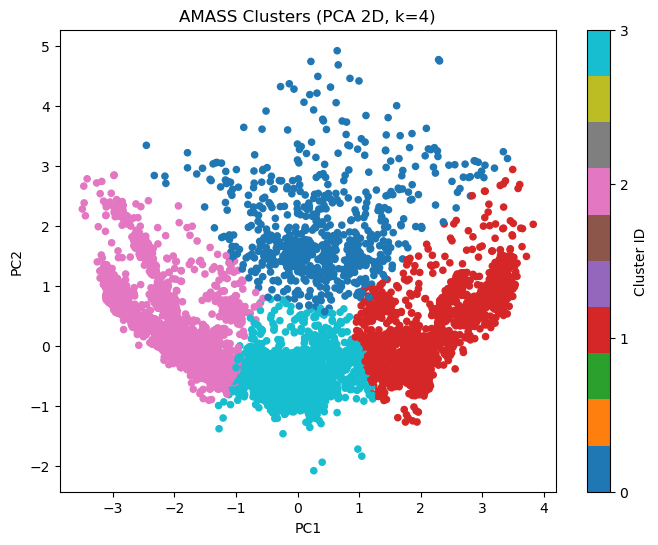

In [9]:
plot_amass_clusters('D:/AMASS/smplh', num_clusters=4)

In [2]:
def generate_batch_datasets(amass_dir, output_base_dir, template_npz, num_datasets=500, num_files_per_blend=4, transition_frames=60):
    """
    블렌딩된 데이터셋을 배치로 생성
    
    Args:
        amass_dir: AMASS 데이터 폴더 경로
        output_base_dir: 출력 기본 디렉토리
        template_npz: 템플릿 NPZ 파일
        num_datasets: 생성할 데이터셋 개수
        num_files_per_blend: 각 블렌딩당 파일 개수
        transition_frames: 트랜지션 프레임 수
    """
    # 출력 폴더 생성
    csv_output_dir = os.path.join(output_base_dir, 'csv')
    npz_output_dir = os.path.join(output_base_dir, 'npz')
    os.makedirs(csv_output_dir, exist_ok=True)
    os.makedirs(npz_output_dir, exist_ok=True)
    
    # 모든 NPZ 파일 목록 미리 로드
    print("AMASS 데이터에서 모든 NPZ 파일 찾는 중...")
    all_npz_files = []
    for root, dirs, files in os.walk(amass_dir):
        for file in files:
            if file.endswith('.npz'):
                full_path = os.path.join(root, file)
                all_npz_files.append(full_path)
    
    print(f"총 {len(all_npz_files)}개의 NPZ 파일을 찾았습니다.")
    
    if len(all_npz_files) < num_files_per_blend:
        print("NPZ 파일이 부족합니다!")
        return
    
    # 전체 로그 데이터 저장용
    all_log_data = []
    successful_datasets = 0
    failed_datasets = 0
    
    print(f"\n{'='*80}")
    print(f"{num_datasets}개 데이터셋 배치 생성 시작!")
    print(f"{'='*80}")
    
    # 500개 데이터셋 생성
    for dataset_num in tqdm(range(1, num_datasets + 1), desc="데이터셋 생성"):
        try:
            # 파일명 생성 (B00001, B00002, ...)
            dataset_id = f"B{dataset_num:05d}"
            
            # 랜덤하게 파일 선택
            selected_files = random.sample(all_npz_files, num_files_per_blend)
            
            # 출력 파일 경로
            csv_output_path = os.path.join(csv_output_dir, f"{dataset_id}.csv")
            
            # 블렌딩 수행
            blended_df = blend_npz_files_with_slerp_transition_batch(
                selected_files, 
                csv_output_path, 
                transition_frames,
                dataset_id
            )
            
            if blended_df is not None:
                # 개별 CSV를 NPZ로 변환
                convert_single_csv_to_npz(csv_output_path, template_npz, npz_output_dir, dataset_id)
                
                # 로그 데이터 수집
                log_entry = create_log_entry(selected_files, len(blended_df), dataset_id, transition_frames)
                all_log_data.append(log_entry)
                
                successful_datasets += 1
                
                # 100개마다 진행 상황 출력
                if dataset_num % 100 == 0:
                    print(f"✅ {dataset_num}개 완료 - 성공: {successful_datasets}, 실패: {failed_datasets}")
                    
            else:
                failed_datasets += 1
                
        except Exception as e:
            failed_datasets += 1
            # 오류는 간단하게만 출력
            if "shape.npz" not in str(e):  # shape.npz 오류는 너무 많아서 제외
                print(f"❌ {dataset_id} 오류: {str(e)[:50]}...")
            continue
    
    # 전체 로그 저장
    if all_log_data:
        log_df = pd.DataFrame(all_log_data)
        log_csv_path = os.path.join(output_base_dir, 'motionBlending.csv')
        log_df.to_csv(log_csv_path, index=False)
        
        print(f"\n{'='*80}")
        print(f"배치 생성 완료!")
        print(f"{'='*80}")
        print(f"✅ 성공: {successful_datasets}개")
        print(f"❌ 실패: {failed_datasets}개")
        print(f"📁 CSV 출력 폴더: {os.path.abspath(csv_output_dir)}")
        print(f"📁 NPZ 출력 폴더: {os.path.abspath(npz_output_dir)}")
        print(f"📋 로그 파일: {os.path.abspath(log_csv_path)}")
        print(f"성공률: {(successful_datasets/num_datasets)*100:.1f}%")
    
    return successful_datasets, failed_datasets

def blend_npz_files_with_slerp_transition_batch(npz_files, output_csv_path, transition_frames, dataset_id):
    """
    배치용 블렌딩 함수 (로그 출력 없음)
    """
    blended_dataframes = []
    
    for i, npz_path in enumerate(npz_files):
        try:
            # NPZ를 DataFrame으로 변환
            df, frame_rate = npz_to_dataframe(npz_path)
            
            # 첫 번째 파일이 아닌 경우 트랜지션 추가
            if blended_dataframes:
                prev_df = blended_dataframes[-1]
                transition_df = interpolate_transition_with_slerp(prev_df, df, transition_frames)
                blended_dataframes.append(transition_df)
            
            # 현재 DataFrame 추가
            blended_dataframes.append(df)
            
        except Exception as e:
            # 오류 발생시 무시하고 계속 진행
            continue
    
    if not blended_dataframes:
        return None
    
    # 모든 DataFrame을 연결
    final_df = pd.concat(blended_dataframes, ignore_index=True)
    
    # CSV로 저장
    final_df.to_csv(output_csv_path, index=False)
    
    return final_df

def convert_single_csv_to_npz(csv_path, template_npz, output_npz_folder, dataset_id):
    """
    단일 CSV를 NPZ로 변환
    """
    try:
        # 템플릿 NPZ 로드
        template = np.load(template_npz, allow_pickle=True)
        gender = template['gender']
        mocap_framerate = template['mocap_framerate']
        betas = template['betas']
        dmpl_dim = template['dmpls'].shape[1]
        
        NUM_JOINTS = 52
        POSE_DIMS = NUM_JOINTS * 3
        
        # CSV 로드
        df = pd.read_csv(csv_path)
        T_csv = len(df)
        
        # pelvis 위치 추출
        trans = df[['pelvis_px','pelvis_py','pelvis_pz']].to_numpy()
        
        # poses 추출
        axes_cols = [c for c in df.columns if re.search(r'_(wx|wy|wz)$', c)]
        joints_csv = []
        for c in axes_cols:
            jn = re.sub(r'_(wx|wy|wz)$', '', c)
            if jn not in joints_csv:
                joints_csv.append(jn)
        num_csv = len(joints_csv)
        
        poses_csv = np.zeros((T_csv, num_csv*3), dtype=np.float64)
        for i, jn in enumerate(joints_csv):
            poses_csv[:, i*3:(i+1)*3] = df[[f'{jn}_wx', f'{jn}_wy', f'{jn}_wz']].to_numpy()
        
        poses_full = np.zeros((T_csv, POSE_DIMS), dtype=np.float64)
        poses_full[:, :num_csv*3] = poses_csv
        
        dmpls = np.zeros((T_csv, dmpl_dim), dtype=np.float64)
        
        # NPZ 저장
        output_npz_path = os.path.join(output_npz_folder, f"{dataset_id}.npz")
        np.savez(
            output_npz_path,
            trans=trans,
            gender=gender,
            mocap_framerate=mocap_framerate,
            betas=betas,
            dmpls=dmpls,
            poses=poses_full,
        )
        
    except Exception as e:
        print(f"    NPZ 변환 오류 {dataset_id}: {e}")

def create_log_entry(npz_files, total_frames, dataset_id, transition_frames):
    """
    로그 엔트리 생성
    """
    log_entry = {
        'dataset_id': dataset_id,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'transition_frames': transition_frames,
        'total_frames': total_frames
    }
    
    # 각 파일 정보 추가
    for i, npz_path in enumerate(npz_files, 1):
        log_entry[f'file_path_{i:02d}'] = os.path.abspath(npz_path)
        log_entry[f'file_name_{i:02d}'] = os.path.basename(npz_path)
    
    return log_entry

In [3]:
# 실행 코드 (배치 생성)
if __name__ == "__main__":
    # 설정
    amass_dir = 'D:/AMASS/smplh'  # AMASS 데이터 폴더 경로
    output_base_dir = 'D:/AMASS/new_dataset_batch2'  # 배치 출력 기본 폴더
    template_npz = 'D:/AMASS/smplh/SFU/0005/0005_JumpRope001_poses.npz'  # 템플릿 NPZ 파일
    
    # 배치 설정
    num_datasets = 20000  # 생성할 데이터셋 개수
    num_files_per_blend = 4  # 각 블렌딩당 파일 개수
    transition_frames = 120  # 트랜지션 프레임 수
    
    print("="*80)
    print("AMASS 모션 블렌딩 배치 생성 시작!")
    print("="*80)
    print(f"생성할 데이터셋 개수: {num_datasets}")
    print(f"각 블렌딩당 파일 개수: {num_files_per_blend}")
    print(f"트랜지션 프레임 수: {transition_frames}")
    print(f"출력 폴더: {output_base_dir}")
    
    # 배치 생성 실행
    successful, failed = generate_batch_datasets(
        amass_dir=amass_dir,
        output_base_dir=output_base_dir,
        template_npz=template_npz,
        num_datasets=num_datasets,
        num_files_per_blend=num_files_per_blend,
        transition_frames=transition_frames
    )
    
    print(f"\n{'='*80}")
    print(f"전체 배치 생성 완료!")
    print(f"{'='*80}")
    print(f"✅ 성공: {successful}/{num_datasets}")
    print(f"❌ 실패: {failed}/{num_datasets}")
    print(f"성공률: {(successful/num_datasets)*100:.1f}%")

AMASS 모션 블렌딩 배치 생성 시작!
생성할 데이터셋 개수: 20000
각 블렌딩당 파일 개수: 4
트랜지션 프레임 수: 120
출력 폴더: D:/AMASS/new_dataset_batch2
AMASS 데이터에서 모든 NPZ 파일 찾는 중...
총 14055개의 NPZ 파일을 찾았습니다.

20000개 데이터셋 배치 생성 시작!


데이터셋 생성: 100%|██████████| 20000/20000 [00:00<00:00, 126612.28it/s]


전체 배치 생성 완료!
✅ 성공: 0/20000
❌ 실패: 20000/20000
성공률: 0.0%


## Text Annotation

### 파일 이름 찾기

In [14]:
import json
import pandas as pd
import os
import csv

# 1) JSON 구조 로드
with open("TMR_humanml3d_annotations.json", "r", encoding="utf-8") as f:
    annotations = json.load(f)

# 2) path → key 매핑 딕셔너리
path_to_key = {info["path"]: key for key, info in annotations.items()}

# 3) CSV 불러오기 (모든 컬럼을 str로)
df = pd.read_csv("D:/AMASS/new_dataset_batch2/motionBlending.csv", dtype=str)

# 4) 접두사 제거 + 정규화 함수
PREFIX = r"D:\AMASS\smplh"
def normalize(p: str) -> str:
    return os.path.splitext(
        p.replace(PREFIX, "").replace("\\", "/").lstrip("/")
    )[0]

# 5) 개선된 매핑 & 제로패딩 함수
def map_and_pad(path_str):
    if pd.isna(path_str) or path_str == "":
        return ""  # 빈 값은 그대로 유지
    
    normalized = normalize(path_str)
    json_key = path_to_key.get(normalized, "")
    
    # 빈 문자열이 아닌 경우만 제로패딩 적용
    if json_key != "":
        return json_key.zfill(6)
    else:
        return ""

# 6) 모든 file_path_* 컬럼에 적용
for col in [c for c in df.columns if c.startswith("file_path_")]:
    df[f"{col}_json_key"] = df[col].apply(map_and_pad)

# 7) 결과 저장
df.to_csv(
    "motionBlending_with_padded_keys.csv",
    index=False,
    quoting=csv.QUOTE_NONNUMERIC
)

print("완료: motionBlending_with_padded_keys.csv 생성됨")

# 8) 결과 검증
print("\n제로패딩 결과 확인:")
for col in [c for c in df.columns if c.endswith("_json_key")]:
    sample_values = df[col].dropna().head(10)
    print(f"{col}: {sample_values.tolist()}")

완료: motionBlending_with_padded_keys.csv 생성됨

제로패딩 결과 확인:
file_path_01_json_key: ['', '010756', '008249', '009428', '000471', '', '', '002906', '', '002973']
file_path_02_json_key: ['', '013893', '009908', '005890', '', '', '008420', '', '001775', '']
file_path_03_json_key: ['002799', '', '013502', '003340', '005750', '005781', '008745', '011434', '007396', '008966']
file_path_04_json_key: ['000662', '013458', '007996', '009658', '001144', '010868', '005656', '002669', '', '009815']


### 단일 데이터 테스트

In [ ]:
# 0) 파일 경로
file_path = 'C:/Users/Velab/Downloads/'

# 1) 입력 파일과 접두사 정의
file_paths = [
    file_path + "000000.txt",  # First
    file_path + "000001.txt",  # Then
    file_path + "000002.txt",  # Then
    file_path + "000003.txt"   # Finally
]
sent_prefixes = ["First,", "Then,", "Then,", "Finally,"]
morph_prefixes = ["First/ADV", "Then/ADV", "Then/ADV", "Finally/ADV"]

# 2) 출력 파일명
output_file = file_path + "merged_0000_0001_0002_0003.txt"

# 3) 각 파일에서 줄 읽어오기
lines_list = []
for path in file_paths:
    with open(path, 'r', encoding='utf-8') as f:
        # 빈 줄 없이 strip된 리스트 생성
        lines = [line.strip() for line in f if line.strip()]
    lines_list.append(lines)

# 4) 줄 수 검증
n = len(lines_list[0])
for idx, lines in enumerate(lines_list):
    if len(lines) != n:
        raise ValueError(f"{file_paths[idx]}의 줄 수({len(lines)})가 {file_paths[0]}({n})와 다릅니다.")

# 5) 병합 및 쓰기
with open(output_file, 'w', encoding='utf-8') as out:
    for i in range(n):
        # 각 파일의 i번째 줄을 '#' 기준으로 분할
        parts = [lines_list[j][i].split('#') for j in range(4)]
        descs  = [p[0].strip() for p in parts]                          # 문장
        morphs = [p[1].strip() if len(p) > 1 else '' for p in parts]    # 기존 품사 태깅
        nums   = parts[0][2:]                                          # 첫 파일의 숫자 태그

        # timing 부분: "#0.0 #0.0" 형태로 재조합
        timing = ' '.join(f"#{num}" for num in nums)

        # 새로운 품사 태깅: First/ADV ... Then/ADV ...
        new_morph = ' '.join(f"{morph_prefixes[j]} {morphs[j]}" for j in range(4)).strip()

        # 문장 부분: First, desc Then, desc ...
        merged_sent = ' '.join(f"{sent_prefixes[j]} {descs[j]}" for j in range(4)).strip()

        # 최종 라인 조립
        merged_line = f"{merged_sent} #{new_morph} {timing}"
        out.write(merged_line + "\n")

print(f"병합 완료: {output_file} (총 {n}줄)")

### 본 코드

In [15]:
import json
import pandas as pd
import os
import csv
from pathlib import Path

def merge_text_files_from_csv(csv_path, txt_folder_path, output_folder_path):
    """
    CSV 파일의 json_key 컬럼들을 읽어서 해당하는 txt 파일들을 병합
    빈 칸이 하나라도 있는 행은 건너뜀
    
    Args:
        csv_path: motionBlending_with_padded_keys.csv 파일 경로
        txt_folder_path: txt 파일들이 있는 폴더 경로
        output_folder_path: 병합된 txt 파일들을 저장할 폴더
    """
    # 출력 폴더 생성
    os.makedirs(output_folder_path, exist_ok=True)
    
    # CSV 파일 로드
    df = pd.read_csv(csv_path, dtype=str)
    
    # json_key 컬럼들 찾기
    json_key_columns = [col for col in df.columns if col.endswith('_json_key')]
    print(f"발견된 json_key 컬럼들: {json_key_columns}")
    
    # 접두사 정의 (4개 파일용)
    sent_prefixes = ["First,", "Then,", "Then,", "Finally,"]
    morph_prefixes = ["First/ADV", "Then/ADV", "Then/ADV", "Finally/ADV"]
    
    successful_merges = 0
    failed_merges = 0
    skipped_empty = 0
    
    # 각 행에 대해 처리
    for idx, row in df.iterrows():
        try:
            # dataset_id 가져오기
            dataset_id = row.get('dataset_id', f'dataset_{idx:05d}')
            
            # json_key 컬럼들에서 빈 값 체크
            json_keys = []
            has_empty = False
            
            for col in json_key_columns:
                json_key = str(row[col]).strip()
                if json_key == "" or json_key == "nan" or pd.isna(row[col]):
                    has_empty = True
                    break
                json_keys.append(json_key)
            
            # 빈 값이 하나라도 있으면 건너뛰기
            if has_empty:
                print(f"[{idx+1}/{len(df)}] ⏭️ 건너뜀: {dataset_id} (빈 값 존재)")
                skipped_empty += 1
                continue
            
            print(f"\n[{idx+1}/{len(df)}] 처리 중: {dataset_id}")
            
            # txt 파일 경로들 수집 및 존재 여부 확인
            txt_file_paths = []
            missing_files = []
            
            for i, json_key in enumerate(json_keys):
                txt_file_path = os.path.join(txt_folder_path, f"{json_key}.txt")
                if os.path.exists(txt_file_path):
                    txt_file_paths.append(txt_file_path)
                    print(f"  ✅ 찾음: {json_key}.txt")
                else:
                    missing_files.append(json_key)
                    print(f"  ❌ 없음: {json_key}.txt")
            
            # 모든 파일이 있는지 확인
            if len(txt_file_paths) != len(json_keys):
                print(f"  ⚠️ 파일 부족: {len(txt_file_paths)}/{len(json_keys)}개 찾음")
                print(f"  누락된 파일들: {missing_files}")
                failed_merges += 1
                continue
            
            # 각 파일에서 줄 읽어오기
            lines_list = []
            for path in txt_file_paths:
                with open(path, 'r', encoding='utf-8') as f:
                    lines = [line.strip() for line in f if line.strip()]
                lines_list.append(lines)
            
            # 줄 수 검증
            if not lines_list:
                print(f"  ❌ 모든 파일이 비어있음")
                failed_merges += 1
                continue
                
            n = len(lines_list[0])
            all_same_length = True
            
            for i, lines in enumerate(lines_list):
                if len(lines) != n:
                    print(f"  ❌ 줄 수 불일치: 파일{i+1}({len(lines)}) vs 파일1({n})")
                    all_same_length = False
                    break
            
            if not all_same_length:
                failed_merges += 1
                continue
            
            if n == 0:
                print(f"  ❌ 모든 파일에 내용이 없음")
                failed_merges += 1
                continue
            
            # 출력 파일 경로 (dataset_id 사용)
            output_file = os.path.join(output_folder_path, f"{dataset_id}.txt")
            
            # 병합 및 쓰기
            with open(output_file, 'w', encoding='utf-8') as out:
                for i in range(n):
                    # 각 파일의 i번째 줄을 '#' 기준으로 분할
                    parts = [lines_list[j][i].split('#') for j in range(len(lines_list))]
                    descs = [p[0].strip() for p in parts]
                    morphs = [p[1].strip() if len(p) > 1 else '' for p in parts]
                    nums = parts[0][2:] if len(parts[0]) > 2 else ['0.0', '0.0']  # 첫 파일의 숫자 태그
                    
                    # timing 부분: "#0.0 #0.0" 형태로 재조합
                    timing = ' '.join(f"#{num}" for num in nums)
                    
                    # 새로운 품사 태깅 (사용된 파일 수만큼)
                    used_morph_prefixes = morph_prefixes[:len(lines_list)]
                    new_morph = ' '.join(f"{used_morph_prefixes[j]} {morphs[j]}" for j in range(len(lines_list))).strip()
                    
                    # 문장 부분 (사용된 파일 수만큼)
                    used_sent_prefixes = sent_prefixes[:len(lines_list)]
                    merged_sent = ' '.join(f"{used_sent_prefixes[j]} {descs[j]}" for j in range(len(lines_list))).strip()
                    
                    # 최종 라인 조립
                    merged_line = f"{merged_sent} #{new_morph} {timing}"
                    out.write(merged_line + "\n")
            
            print(f"  ✅ 병합 완료: {output_file} (총 {n}줄)")
            successful_merges += 1
            
        except Exception as e:
            print(f"  ❌ 오류 발생 {dataset_id}: {str(e)}")
            failed_merges += 1
            continue
    
    # 최종 결과 출력
    print(f"\n{'='*80}")
    print(f"텍스트 파일 병합 완료!")
    print(f"{'='*80}")
    print(f"✅ 성공: {successful_merges}개")
    print(f"❌ 실패: {failed_merges}개")
    print(f"⏭️ 건너뜀 (빈 값): {skipped_empty}개")
    print(f"📁 출력 폴더: {os.path.abspath(output_folder_path)}")
    
    total_processed = successful_merges + failed_merges + skipped_empty
    if total_processed > 0:
        print(f"성공률: {(successful_merges/total_processed)*100:.1f}%")
        print(f"유효 데이터 비율: {((successful_merges + failed_merges)/total_processed)*100:.1f}%")

In [17]:
# 실행 코드
if __name__ == "__main__":
    
    csv_file_path = "D:/HumanML3D-main/motionBlending_with_padded_keys.csv"  # CSV 파일 경로
    txt_folder_path = "D:/HumanML3D-main/HumanML3D/texts_org/"  # txt 파일들이 있는 폴더
    output_folder_path = "D:/HumanML3D-main/HumanML3D/tmp/"  # 병합된 txt 출력 폴더
    
    print("="*80)
    print("CSV 기반 텍스트 파일 자동 병합 시작!")
    print("="*80)
    print(f"CSV 파일: {csv_file_path}")
    print(f"텍스트 폴더: {txt_folder_path}")
    print(f"출력 폴더: {output_folder_path}")
    
    # 병합 실행
    merge_text_files_from_csv(csv_file_path, txt_folder_path, output_folder_path)

CSV 기반 텍스트 파일 자동 병합 시작!
CSV 파일: D:/HumanML3D-main/motionBlending_with_padded_keys.csv
텍스트 폴더: D:/HumanML3D-main/HumanML3D/texts_org/
출력 폴더: D:/HumanML3D-main/HumanML3D/tmp/
발견된 json_key 컬럼들: ['file_path_01_json_key', 'file_path_02_json_key', 'file_path_03_json_key', 'file_path_04_json_key']
[1/20000] ⏭️ 건너뜀: B00001 (빈 값 존재)
[2/20000] ⏭️ 건너뜀: B00002 (빈 값 존재)

[3/20000] 처리 중: B00003
  ✅ 찾음: 008249.txt
  ✅ 찾음: 009908.txt
  ✅ 찾음: 013502.txt
  ✅ 찾음: 007996.txt
  ✅ 병합 완료: D:/HumanML3D-main/HumanML3D/tmp/B00003.txt (총 3줄)

[4/20000] 처리 중: B00004
  ✅ 찾음: 009428.txt
  ✅ 찾음: 005890.txt
  ✅ 찾음: 003340.txt
  ✅ 찾음: 009658.txt
  ✅ 병합 완료: D:/HumanML3D-main/HumanML3D/tmp/B00004.txt (총 3줄)
[5/20000] ⏭️ 건너뜀: B00005 (빈 값 존재)
[6/20000] ⏭️ 건너뜀: B00006 (빈 값 존재)
[7/20000] ⏭️ 건너뜀: B00007 (빈 값 존재)
[8/20000] ⏭️ 건너뜀: B00008 (빈 값 존재)
[9/20000] ⏭️ 건너뜀: B00009 (빈 값 존재)
[10/20000] ⏭️ 건너뜀: B00010 (빈 값 존재)
[11/20000] ⏭️ 건너뜀: B00011 (빈 값 존재)
[12/20000] ⏭️ 건너뜀: B00012 (빈 값 존재)
[13/20000] ⏭️ 건너뜀: B00013 (빈 값 존재)
[14/2000

### Augmentation용 텍스트 파일 생성

In [18]:
import os
import re
from pathlib import Path

def swap_left_right_in_text(text):
    """
    텍스트에서 left와 right를 서로 바꾸는 함수
    
    Args:
        text (str): 원본 텍스트
    
    Returns:
        str: left/right가 바뀐 텍스트
    """
    # 임시 플레이스홀더 사용하여 중복 변환 방지
    placeholder_left = "###TEMP_LEFT###"
    placeholder_right = "###TEMP_RIGHT###"
    
    # 1단계: left를 임시 플레이스홀더로 변경 (단어 경계 고려)
    text = re.sub(r'\bleft\b', placeholder_left, text, flags=re.IGNORECASE)
    
    # 2단계: right를 left로 변경 (단어 경계 고려)
    text = re.sub(r'\bright\b', 'left', text, flags=re.IGNORECASE)
    
    # 3단계: 임시 플레이스홀더를 right로 변경
    text = text.replace(placeholder_left, 'right')
    
    return text

def create_mirrored_text_files(input_folder, output_folder=None):
    """
    폴더 내 모든 txt 파일에서 left/right를 바꾼 새 파일들을 생성
    
    Args:
        input_folder (str): 원본 txt 파일들이 있는 폴더
        output_folder (str): 출력 폴더 (None이면 input_folder와 동일)
    """
    input_path = Path(input_folder)
    
    # 출력 폴더 설정
    if output_folder is None:
        output_path = input_path
    else:
        output_path = Path(output_folder)
        os.makedirs(output_path, exist_ok=True)
    
    # txt 파일들 찾기
    txt_files = list(input_path.glob("*.txt"))
    
    if not txt_files:
        print(f"❌ '{input_folder}' 폴더에서 txt 파일을 찾을 수 없습니다.")
        return
    
    print(f"📁 입력 폴더: {input_path.absolute()}")
    print(f"📁 출력 폴더: {output_path.absolute()}")
    print(f"📊 발견된 txt 파일: {len(txt_files)}개")
    print("="*80)
    
    successful_count = 0
    failed_count = 0
    
    for txt_file in txt_files:
        try:
            # 원본 파일명에서 확장자 제거
            original_name = txt_file.stem
            
            # M 접두사 추가된 새 파일명
            new_filename = f"M{original_name}.txt"
            output_file_path = output_path / new_filename
            
            print(f"🔄 처리 중: {txt_file.name} → {new_filename}")
            
            # 원본 파일 읽기
            with open(txt_file, 'r', encoding='utf-8') as f:
                content = f.read()
            
            # left/right 바꾸기
            mirrored_content = swap_left_right_in_text(content)
            
            # 새 파일로 저장
            with open(output_file_path, 'w', encoding='utf-8') as f:
                f.write(mirrored_content)
            
            print(f"  ✅ 완료: {output_file_path.name}")
            successful_count += 1
            
        except Exception as e:
            print(f"  ❌ 오류 발생: {txt_file.name} - {str(e)}")
            failed_count += 1
            continue
    
    # 최종 결과 출력
    print("="*80)
    print("Left/Right 미러링 완료!")
    print("="*80)
    print(f"✅ 성공: {successful_count}개")
    print(f"❌ 실패: {failed_count}개")
    print(f"📁 출력 폴더: {output_path.absolute()}")
    
    if successful_count > 0:
        print(f"\n📋 생성된 파일 예시:")
        mirrored_files = list(output_path.glob("M*.txt"))[:5]  # 처음 5개만 표시
        for file in mirrored_files:
            print(f"  - {file.name}")
    
    return successful_count, failed_count

def preview_text_changes(input_folder, sample_file=None):
    """
    변환 결과를 미리보기하는 함수
    
    Args:
        input_folder (str): txt 파일들이 있는 폴더
        sample_file (str): 특정 파일명 (None이면 첫 번째 파일 사용)
    """
    input_path = Path(input_folder)
    txt_files = list(input_path.glob("*.txt"))
    
    if not txt_files:
        print("미리보기할 txt 파일이 없습니다.")
        return
    
    # 샘플 파일 선택
    if sample_file:
        sample_path = input_path / sample_file
        if not sample_path.exists():
            print(f"파일을 찾을 수 없습니다: {sample_file}")
            return
    else:
        sample_path = txt_files[0]
    
    print(f"📋 미리보기 파일: {sample_path.name}")
    print("="*80)
    
    try:
        # 원본 파일 읽기
        with open(sample_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # 처음 3줄만 미리보기
        for i, line in enumerate(lines[:3], 1):
            original = line.strip()
            mirrored = swap_left_right_in_text(original)
            
            print(f"줄 {i}:")
            print(f"  원본: {original}")
            print(f"  변환: {mirrored}")
            print()
    
    except Exception as e:
        print(f"미리보기 오류: {e}")

In [19]:
# 실행 코드
if __name__ == "__main__":
    # 설정
    input_folder = "D:/HumanML3D-main/HumanML3D/tmp/"  # 원본 txt 파일들이 있는 폴더
    output_folder = None  # None이면 input_folder와 같은 폴더에 저장
    
    print("="*80)
    print("텍스트 파일 Left/Right 미러링 시작!")
    print("="*80)
    
    # 미리보기 (선택사항)
    print("📋 변환 미리보기:")
    preview_text_changes(input_folder)
    
    # 실제 변환 실행
    successful, failed = create_mirrored_text_files(input_folder, output_folder)
    
    print(f"\n{'='*80}")
    print(f"전체 프로세스 완료!")
    print(f"{'='*80}")
    print(f"처리된 파일: {successful + failed}개")
    print(f"성공률: {(successful/(successful + failed))*100:.1f}%" if (successful + failed) > 0 else "N/A")

텍스트 파일 Left/Right 미러링 시작!
📋 변환 미리보기:
📋 미리보기 파일: B00003.txt
줄 1:
  원본: First, a man plays the violin the goes back to his original position. Then, moving forward on the floor. Then, shuffle step right then side stepping back left Finally, a person turns slightly to the right, throws an object, then catches something with both hands #First/ADV a/DET man/NOUN play/VERB the/DET violin/NOUN the/DET go/VERB back/ADV to/ADP his/DET original/ADJ position/NOUN Then/ADV move/VERB forward/ADV on/ADP the/DET floor/NOUN Then/ADV shuffle/PROPN step/PROPN right/ADV then/ADV side/NOUN step/VERB back/ADV left/ADV Finally/ADV a/DET person/NOUN turn/VERB slightly/ADV to/ADP the/DET right/NOUN throw/VERB an/DET object/NOUN then/ADV catch/VERB something/PRON with/ADP both/DET hand/NOUN #0.0 #0.0
  변환: First, a man plays the violin the goes back to his original position. Then, moving forward on the floor. Then, shuffle step left then side stepping back right Finally, a person turns slightly to the left, thr

In [9]:
# 임시: 파일 복사 어그멘테이션 코드

# 폴더 내 파일들을 복사하면서 파일명 끝(확장자 앞)에 _augmentedNN 접미사를 붙이는 원셀 스크립트
# 사용법:
#  1) 아래 파라미터만 수정 후 셀 한 번 실행
#  2) DRY_RUN=True로 먼저 생성될 이름만 점검 권장

from pathlib import Path
import shutil
import re

# ===== 파라미터 =====
FOLDER = Path("D:/HumanML3D-main/HumanML3D_mopric(두개)/texts")  # <- 수정
PATTERN = "*"                     # 예: "*.jpg", "*.png"
COPIES = 25                       # 파일당 생성 개수
START = 1                         # 시작 번호 (1 → 01)
PAD = 2                           # 번호 자릿수 (2 → 01, 02)
SKIP_AUGMENTED = False            # 이미 _augmentedNN인 파일은 건너뛰기
DRY_RUN = False                   # True면 미리보기만(복사 안 함)
# ====================

AUG_PAT = re.compile(r"(.*)_augmented(\d+)$")

def split_name_and_all_suffixes(p: Path):
    """다중 확장자(.tar.gz 등) 포함 처리: (기본이름, 전체확장자문자열) 반환"""
    if len(p.suffixes) > 1:
        suffixes = ''.join(p.suffixes)
        base = p.name[:-len(suffixes)].rstrip('.')
        return base, suffixes
    return p.stem, p.suffix

def is_augmented_name(p: Path) -> bool:
    base, _ = split_name_and_all_suffixes(p)
    return AUG_PAT.fullmatch(base) is not None

def make_name(src: Path, idx: int, pad: int) -> Path:
    base, suffixes = split_name_and_all_suffixes(src)
    new_stem = f"{base}_augmented{str(idx).zfill(pad)}"
    return src.with_name(new_stem + (suffixes or ''))

# 입력 검증
if not FOLDER.exists():
    raise SystemExit(f"폴더가 존재하지 않음: {FOLDER}")
if not FOLDER.is_dir():
    raise SystemExit(f"폴더가 아님: {FOLDER}")

print(f"대상 폴더: {FOLDER.resolve()}")

# 실행
files = [f for f in FOLDER.glob(PATTERN) if f.is_file()]
files.sort()
print(f"대상 파일 수: {len(files)} (패턴: {PATTERN})")

created = 0
skipped_exist = 0
skipped_aug = 0

for src in files:
    if SKIP_AUGMENTED and is_augmented_name(src):
        print(f"건너뜀(이미 augmented): {src.name}")
        skipped_aug += 1
        continue
    for i in range(START, START + COPIES):
        dst = make_name(src, i, PAD)
        if dst.exists():
            print(f"건너뜀(이미 존재): {dst.name}")
            skipped_exist += 1
            continue
        if DRY_RUN:
            print(f"[DRY] 생성 예정: {dst.name}")
        else:
            shutil.copy2(src, dst)
            print(f"복사: {src.name} -> {dst.name}")
            created += 1

print("\n=== 요약 ===")
print(f"생성: {created}")
print(f"건너뜀(이미 존재): {skipped_exist}")
print(f"건너뜀(이미 augmented): {skipped_aug}")



대상 폴더: D:\HumanML3D-main\HumanML3D_mopric(두개)\texts
대상 파일 수: 410 (패턴: *)
복사: a0001.txt -> a0001_augmented01.txt
복사: a0001.txt -> a0001_augmented02.txt
복사: a0001.txt -> a0001_augmented03.txt
복사: a0001.txt -> a0001_augmented04.txt
복사: a0001.txt -> a0001_augmented05.txt
복사: a0001.txt -> a0001_augmented06.txt
복사: a0001.txt -> a0001_augmented07.txt
복사: a0001.txt -> a0001_augmented08.txt
복사: a0001.txt -> a0001_augmented09.txt
복사: a0001.txt -> a0001_augmented10.txt
복사: a0001.txt -> a0001_augmented11.txt
복사: a0001.txt -> a0001_augmented12.txt
복사: a0001.txt -> a0001_augmented13.txt
복사: a0001.txt -> a0001_augmented14.txt
복사: a0001.txt -> a0001_augmented15.txt
복사: a0001.txt -> a0001_augmented16.txt
복사: a0001.txt -> a0001_augmented17.txt
복사: a0001.txt -> a0001_augmented18.txt
복사: a0001.txt -> a0001_augmented19.txt
복사: a0001.txt -> a0001_augmented20.txt
복사: a0001.txt -> a0001_augmented21.txt
복사: a0001.txt -> a0001_augmented22.txt
복사: a0001.txt -> a0001_augmented23.txt
복사: a0001.txt -> a0001_augment

## 메타데이터 생성

In [14]:
# 파일 목록을 TXT로 저장하는 스크립트 예시
import os

def write_basename_list(directory: str, output_txt: str) -> None:
    """
    지정한 폴더 내 모든 파일의 확장자를 제외한 기본 이름(basename)을
    한 줄씩 TXT 파일에 저장합니다.
    
    Args:
        directory (str): 파일 목록을 읽어올 폴더 경로
        output_txt (str): 결과를 저장할 TXT 파일 경로
    """
    # 폴더 내 엔트리 중 파일만 필터링
    filenames = [
        f for f in os.listdir(directory)
        if os.path.isfile(os.path.join(directory, f))
    ]
    
    # 확장자 제거한 basename 리스트
    basenames = [os.path.splitext(f)[0] for f in filenames]
    
    # 알파벳·숫자 순 정렬(Optional)
    basenames.sort()
    
    # TXT 파일에 기록
    with open(output_txt, 'w', encoding='utf-8') as out:
        for name in basenames:
            out.write(name + '\n')
    
    print(f"✅ '{directory}' 내 {len(basenames)}개의 파일 이름(확장자 제외)을 '{output_txt}'에 저장했습니다.")


# 사용 예시
if __name__ == "__main__":
    # 1) 목록을 만들고 싶은 폴더 경로
    directory = r"D:/HumanML3D-main/HumanML3D_mopric(두개)/new_joints/"
    # 2) 저장할 TXT 파일 경로
    output_txt = "all.txt"
    
    write_basename_list(directory, output_txt)

✅ 'D:/HumanML3D-main/HumanML3D_mopric(두개)/new_joints/' 내 10608개의 파일 이름(확장자 제외)을 'all.txt'에 저장했습니다.


In [15]:
import random
import os

def split_file_list_8_1_1(input_txt: str, output_dir: str = None):
    """
    파일 목록을 train:val:test = 8:1:1 비율로 분할하는 함수
    
    Args:
        input_txt (str): 입력 파일 경로 (all.txt)
        output_dir (str): 출력 디렉토리 (None이면 입력 파일과 같은 위치)
    """
    # 출력 디렉토리 설정
    if output_dir is None:
        output_dir = os.path.dirname(input_txt) if os.path.dirname(input_txt) else '.'
    os.makedirs(output_dir, exist_ok=True)
    
    # 1) 입력 파일 읽기
    with open(input_txt, 'r', encoding='utf-8') as f:
        all_lines = [line.strip() for line in f if line.strip()]
    
    total_count = len(all_lines)
    
    # 2) 8:1:1 비율 계산
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1
    
    train_count = int(total_count * train_ratio)
    val_count = int(total_count * val_ratio)
    test_count = total_count - train_count - val_count  # 나머지는 test에
    
    print(f"📊 전체 파일 수: {total_count}")
    print(f"📊 훈련 파일 수: {train_count} ({train_ratio*100:.1f}%)")
    print(f"📊 검증 파일 수: {val_count} ({val_ratio*100:.1f}%)")
    print(f"📊 테스트 파일 수: {test_count} ({(test_count/total_count)*100:.1f}%)")
    
    # 3) 랜덤 섞기 (재현 가능하도록 시드 설정)
    random.seed(42)  # 동일한 결과를 위해 시드 고정
    shuffled_lines = all_lines.copy()
    random.shuffle(shuffled_lines)
    
    # 4) 분할
    train_lines = shuffled_lines[:train_count]
    val_lines = shuffled_lines[train_count:train_count + val_count]
    test_lines = shuffled_lines[train_count + val_count:]
    
    # 5) 출력 파일 경로 설정
    train_txt = os.path.join(output_dir, "train.txt")
    val_txt = os.path.join(output_dir, "val.txt")
    test_txt = os.path.join(output_dir, "test.txt")
    train_val_txt = os.path.join(output_dir, "train_val.txt")
    
    # 6) 각 파일 저장 (알파벳 순 정렬)
    files_to_save = {
        'train.txt': sorted(train_lines),
        'val.txt': sorted(val_lines),
        'test.txt': sorted(test_lines),
        'train_val.txt': sorted(train_lines + val_lines)  # train + val 합친 것
    }
    
    for filename, lines in files_to_save.items():
        filepath = os.path.join(output_dir, filename)
        with open(filepath, 'w', encoding='utf-8') as f:
            for line in lines:
                f.write(line + '\n')
        print(f"✅ 저장: {filepath} ({len(lines)}개)")
    
    # 7) 검증 출력
    print(f"\n🔍 결과 검증:")
    print(f"train.txt: {len(train_lines)}개")
    print(f"val.txt: {len(val_lines)}개")
    print(f"test.txt: {len(test_lines)}개")
    print(f"train_val.txt: {len(train_lines + val_lines)}개")
    print(f"총합: {len(train_lines) + len(val_lines) + len(test_lines)} (원본: {total_count})")
    
    # 8) 샘플 미리보기
    print(f"\n📋 train.txt 샘플 (처음 3개):")
    for line in sorted(train_lines)[:3]:
        print(f"  {line}")
    
    print(f"\n📋 val.txt 샘플 (처음 3개):")
    for line in sorted(val_lines)[:3]:
        print(f"  {line}")
    
    print(f"\n📋 test.txt 샘플 (처음 3개):")
    for line in sorted(test_lines)[:3]:
        print(f"  {line}")
    
    return {
        'train': train_lines,
        'val': val_lines,
        'test': test_lines,
        'train_val': train_lines + val_lines
    }

In [16]:
# 실행 코드
if __name__ == "__main__":
    # all.txt 파일 경로
    input_file = "D:/HumanML3D-main/HumanML3D_mopric(두개)/all.txt"
    
    print("="*80)
    print("파일 목록 8:1:1 분할 시작!")
    print("="*80)
    
    # 파일 존재 여부 확인
    if not os.path.exists(input_file):
        print(f"❌ 파일을 찾을 수 없습니다: {input_file}")
        print(f"현재 작업 디렉토리: {os.getcwd()}")
        print(f"현재 폴더의 txt 파일들:")
        for f in os.listdir('.'):
            if f.endswith('.txt'):
                print(f"  - {f}")
    else:
        # 8:1:1 분할 실행
        result = split_file_list_8_1_1(input_file)
        
        print(f"\n{'='*80}")
        print(f"8:1:1 분할 완료!")
        print(f"{'='*80}")
        print(f"📁 생성된 파일들:")
        print(f"  - train.txt ({len(result['train'])}개)")
        print(f"  - val.txt ({len(result['val'])}개)")
        print(f"  - test.txt ({len(result['test'])}개)")
        print(f"  - train_val.txt ({len(result['train_val'])}개)")

파일 목록 8:1:1 분할 시작!
📊 전체 파일 수: 10608
📊 훈련 파일 수: 8486 (80.0%)
📊 검증 파일 수: 1060 (10.0%)
📊 테스트 파일 수: 1062 (10.0%)
✅ 저장: D:/HumanML3D-main/HumanML3D_mopric(두개)\train.txt (8486개)
✅ 저장: D:/HumanML3D-main/HumanML3D_mopric(두개)\val.txt (1060개)
✅ 저장: D:/HumanML3D-main/HumanML3D_mopric(두개)\test.txt (1062개)
✅ 저장: D:/HumanML3D-main/HumanML3D_mopric(두개)\train_val.txt (9546개)

🔍 결과 검증:
train.txt: 8486개
val.txt: 1060개
test.txt: 1062개
train_val.txt: 9546개
총합: 10608 (원본: 10608)

📋 train.txt 샘플 (처음 3개):
  Ma0001
  Ma0001_augmented01
  Ma0001_augmented02

📋 val.txt 샘플 (처음 3개):
  Ma0001_augmented25
  Ma0002_augmented20
  Ma0004_augmented06

📋 test.txt 샘플 (처음 3개):
  Ma0001_augmented06
  Ma0001_augmented09
  Ma0001_augmented18

8:1:1 분할 완료!
📁 생성된 파일들:
  - train.txt (8486개)
  - val.txt (1060개)
  - test.txt (1062개)
  - train_val.txt (9546개)
